In [1]:
%load_ext autoreload
%autoreload 2
from common import *
from envs import *
from copy import deepcopy
from RiskAverseMCTS import RiskAverseMCTS
from RiskAverseSparseSampler import RiskAverseSparseSampler
from RiskAverseMarkovAgent import RiskAverseMarkovAgent
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

In [12]:
N_alpha = 3
N_params = 4
N_rollouts = 100
N_iter = 100
alpha_vals = np.linspace(0.2,1.0,N_alpha)
param_vals = np.arange(N_params)
#mdps = [LavaGoalOneD(param=p) for p in param_vals]
mdps = [TreatmentPlan(param=p) for p in param_vals]
rewards = np.zeros([N_alpha, N_params, N_rollouts])
belief = [0.15, 0.55, 0.15, 0.15] #np.ones(N_params, dtype='float')/N_params

In [14]:
np.round(mdps[0].transition_probs*100)/100

array([[[ 0.03,  0.03,  0.09,  0.77,  0.04,  0.03,  0.  ],
        [ 0.02,  0.  ,  0.04,  0.06,  0.12,  0.68,  0.08],
        [ 0.07,  0.08,  0.61,  0.01,  0.11,  0.09,  0.02]],

       [[ 0.03,  0.09,  0.17,  0.01,  0.  ,  0.06,  0.63],
        [ 0.07,  0.02,  0.07,  0.1 ,  0.7 ,  0.02,  0.03],
        [ 0.07,  0.1 ,  0.09,  0.08,  0.03,  0.58,  0.05]],

       [[ 0.65,  0.04,  0.06,  0.08,  0.05,  0.03,  0.1 ],
        [ 0.05,  0.03,  0.69,  0.05,  0.05,  0.06,  0.07],
        [ 0.07,  0.  ,  0.03,  0.1 ,  0.  ,  0.03,  0.77]],

       [[ 0.01,  0.05,  0.04,  0.75,  0.01,  0.03,  0.11],
        [ 0.78,  0.02,  0.04,  0.  ,  0.08,  0.06,  0.02],
        [ 0.01,  0.05,  0.05,  0.01,  0.06,  0.74,  0.08]]])

In [11]:
mean_transition_model = np.mean(mdps[0].transition_probs, axis=0)
mean_transition_model

array([[ 0.4172302 ,  0.04672645,  0.16925795,  0.07393564,  0.05286624,
         0.05450774,  0.18547577],
       [ 0.02482287,  0.24175783,  0.23490332,  0.04166021,  0.21985519,
         0.19536702,  0.04163356],
       [ 0.04857226,  0.36167055,  0.06526732,  0.05084721,  0.06318704,
         0.35324514,  0.05721048],
       [ 0.08426967,  0.19527775,  0.22831727,  0.19121803,  0.23900626,
         0.03972674,  0.02218428]])

We perform a rollout on every MDP with every $\alpha$ value

In [38]:
rewards = np.zeros([N_alpha, N_params, N_rollouts])
for i, alpha in enumerate(alpha_vals):
    agent = RiskAverseSparseSampler(mdps, belief, max_depth=4, 
                               alpha=alpha, n_iter=1500, K=5, n_burn_in=0, c=1  )
    for j, mdp in enumerate(mdps):
        agent.reset_belief()
        env = Env(mdp, agent)
        stats = env.rollout(n_rollouts=N_rollouts, render=False)
        rewards[i,j,:] = stats.total_rewards
        print("\r a =",alpha,"\tmdp",j,"reward:", np.mean(stats.total_rewards), end='', flush='True')
    print("\r a =",alpha,"\tavg_r:",np.mean(rewards[i,:,:]), "\tvar_r:", np.var(np.mean(rewards[i,:,:], axis=1)), flush='True')

 a = 0.2 	avg_r: 1.209 	var_r: 0.0040425
 a = 0.6 	avg_r: 1.3865 	var_r: 1.31466725
 a = 1.0 	avg_r: 1.45725 	var_r: 1.3968046875


In [41]:
np.save("patient_treatment_rewards_weighted_prior_3.npy", rewards)

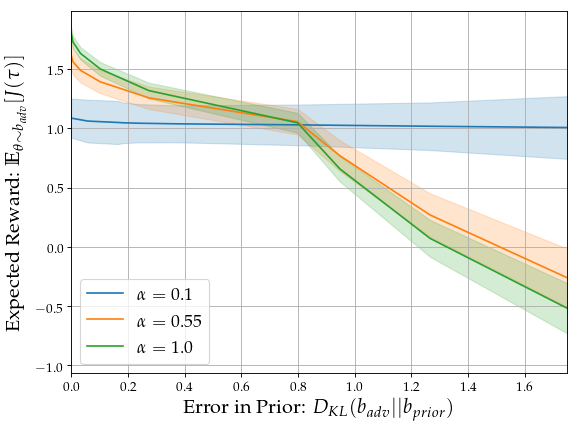

In [59]:
from scipy import optimize
from scipy import stats

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

rewards = np.load("patient_treatment_rewards_weighted_prior_2.npy")
alpha_vals_to_use = [0.1, 0.55, 1.0]

mean_perf = np.mean(rewards, axis=2)
cov_perf = np.zeros([N_alpha, N_params, N_params])
for i in range(N_alpha):
    cov_perf[i,:,:] = np.cov(rewards[i,:,:])

N_perturb_pts = 10
perturb_amts = np.linspace(0.0,1.0,N_perturb_pts)
kl_divs = np.zeros([N_alpha,N_perturb_pts])
perturbed_perf = np.zeros([N_alpha,N_perturb_pts])
perturbed_perf_std = np.zeros([N_alpha,N_perturb_pts])

plt.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
for i, alpha in enumerate(alpha_vals_to_use):
    for j, alpha_perturb in enumerate(perturb_amts):
        Aeq = np.ones((1,N_params))
        beq = 1
        A1 = alpha_perturb*np.eye(N_params)
        b1 = belief
        A2 = -np.eye(N_params)
        b2 = np.zeros(N_params)
        A = np.vstack([A1,A2])
        b = np.vstack([b1, b2])
        res = optimize.linprog(mean_perf[i,:], A, b, Aeq, beq)
        kl_divs[i,j] = stats.entropy(res.x, qk=belief)
        perturbed_perf[i,j] = np.dot(res.x, mean_perf[i,:])
        perturbed_perf_std[i,j] = np.sqrt( np.dot(res.x, np.dot(cov_perf[i,:,:], res.x.T))/ N_rollouts )

    h, = plt.plot(kl_divs[i,:], perturbed_perf[i,:], label=r"$\alpha="+str(alpha)+r"$")
    plt.fill_between(kl_divs[i,:], perturbed_perf[i,:]+1.645*perturbed_perf_std[i,:], 
                     perturbed_perf[i,:]-1.645*perturbed_perf_std[i,:], color=h.get_color(), alpha=0.2)

plt.legend(fontsize=16, loc=3)
plt.grid()
plt.xlim([0, 1.75])
plt.xlabel(r"Error in Prior: $D_{KL}(b_{adv} || b_{prior})$", fontsize=18)
plt.ylabel(r"Expected Reward: $\mathbb{E}_{\theta \sim b_{adv}}[J(\tau)]$", fontsize=18)
plt.savefig('patient_treatment_misspecified_prior.pdf')
plt.show()

/home/apoorva/.envs/adapt/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


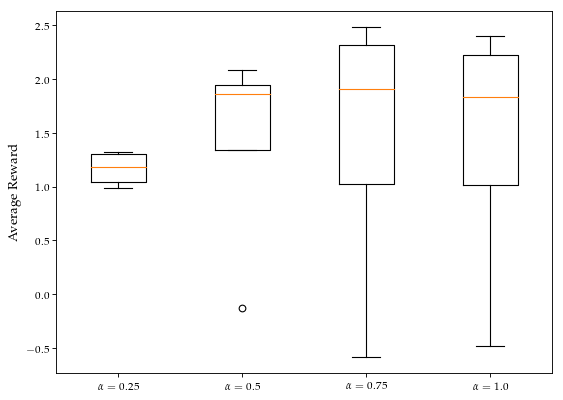

In [7]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
labels = [r"$\alpha="+str(a)+r"$" for a in alpha_vals]
plt.boxplot(np.mean(rewards[:,:,:], axis=2).T, labels=labels)
#plt.title("Distribution of Average Total Rewared over Model Uncertainty", fontsize=18)
plt.ylabel("Average Reward", fontsize=12)
#plt.xlabel("Avg Total Cost under Model", fontsize=16)
plt.legend(fontsize=16)
#plt.savefig('performance_gridworld_spreads_5.pdf')
plt.show()

TODO: put figure below in appendix

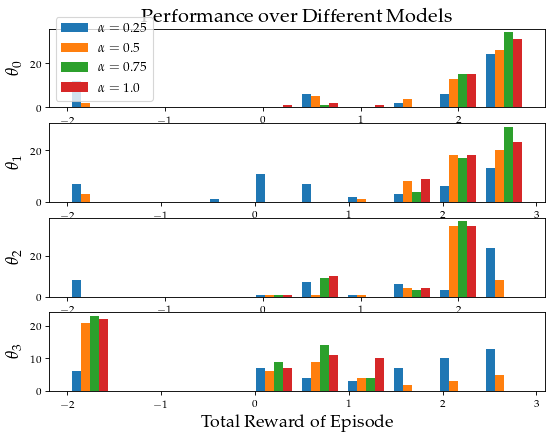

In [10]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(N_params):
    plt.subplot(N_params, 1, i+1)
    labels = [r"$\alpha="+str(a)+r"$" for a in alpha_vals]
    plt.hist(rewards[:,i,:].T, label=labels)
    if i == 0:
        plt.title("Performance over Different Models", fontsize=18)
        plt.legend(fontsize=12, )
    plt.ylabel(r"$\theta_"+str(i)+r"$", fontsize=16)
    if i == N_params - 1:
        plt.xlabel("Total Reward of Episode", fontsize=16)
#plt.savefig('performance_per_model.pdf')
plt.show()

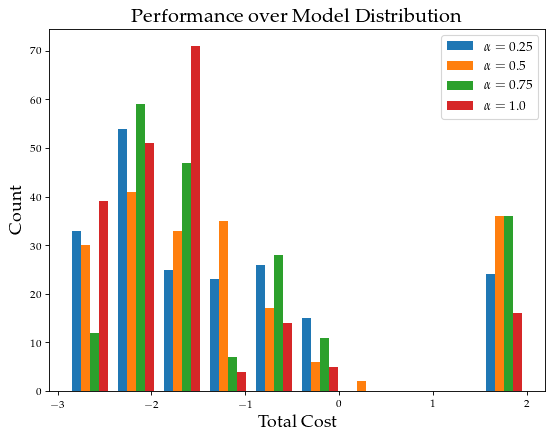

In [7]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
labels = [r"$\alpha="+str(a)+r"$" for a in alpha_vals]
plt.hist(np.reshape(-rewards, [4, -1]).T, label=labels)
plt.title("Performance over Model Distribution", fontsize=18)
plt.ylabel("Count", fontsize=16)
plt.xlabel("Total Cost", fontsize=16)
plt.legend(fontsize=12)
#plt.savefig('performance_bandit.pdf')
plt.show()

# Convergence plots

In [7]:
belief_curves = []
br_belief_curves = []
avg_belief_curves = []
agent_value_curves = []
adv_value_curves = []
model_value_curves = []
Q_val_curves = []
final_q_vals = []
final_n_vals = []
for i, alpha in enumerate([0.5,1.0]):
#     agent = RiskAverseMCTS(mdps, belief, max_depth=4, 
#                                alpha=alpha, max_r=2., n_iter=500, K=50, n_burn_in=0  )
    agent = RiskAverseSparseSampler(mdps, belief, max_depth=4, 
                               alpha=alpha, n_iter=1250, K=5, n_burn_in=0, c=1  )
    s0 = mdps[0].reset()
    agent.plan(s0)
    belief_curves.append(deepcopy(agent.adv_dists))
    br_belief_curves.append(deepcopy(agent.adv_brs))
    avg_belief_curves.append(deepcopy(agent.adv_avg))
    agent_value_curves.append(deepcopy(agent.agent_est_value))
    adv_value_curves.append(deepcopy(agent.adv_est_value))
    Q_val_curves.append(deepcopy(agent.agent_Q_vals))
    model_value_curves.append(deepcopy(agent.model_value_history))
    final_q_vals.append( [agent.Qha[(s0,a)] for a in mdps[0].action_space(s0)] )
    final_n_vals.append( [agent.Wha_br[(s0,a)] for a in mdps[0].action_space(s0)] )

AttributeError: 'RiskAverseSparseSampler' object has no attribute 'adv_dists'

In [324]:
(1 - np.array(final_q_vals)).T

array([[ 0.80224377,  0.80750344,  0.82459987,  0.81688312,  0.78526472,
         0.83660131],
       [ 0.82170284,  0.76193088,  0.72291872,  0.68491661,  0.64258941,
         0.68222222],
       [ 0.86089425,  0.78325537,  0.71326761,  0.65560368,  0.62216598,
         0.57296137],
       [ 0.98813056,  0.87374245,  0.77176163,  0.66234143,  0.57950075,
         0.51984601]])

In [325]:
np.array(final_n_vals).T

array([[ 5259.        ,  1697.        ,   651.57142857,   385.        ,
          300.11111111,   153.        ],
       [ 2995.        ,  4861.33333333,  3486.85714286,  2068.5       ,
         1422.88888889,   450.        ],
       [ 1409.        ,  2779.        ,  4550.28571429,  4097.75      ,
         2063.22222222,  1864.        ],
       [  337.        ,   662.66666667,  1311.28571429,  3448.75      ,
         6213.77777778,  7533.        ]])

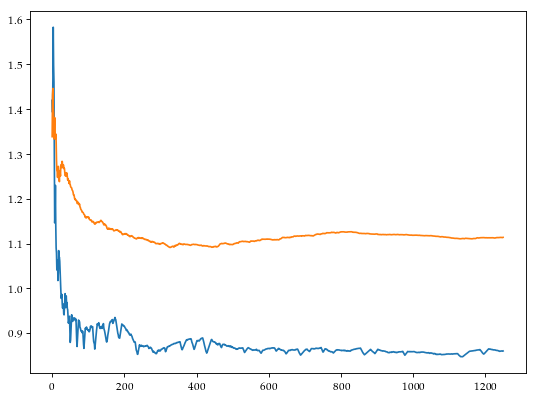

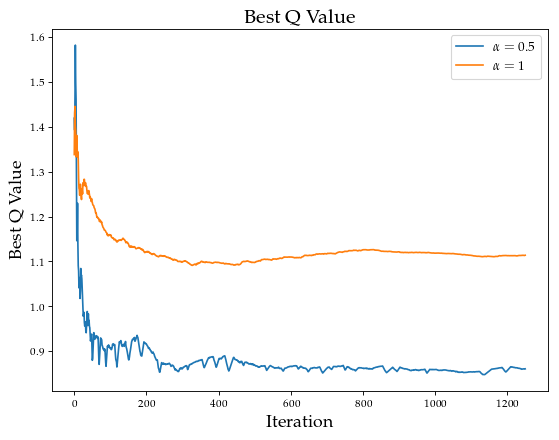

In [22]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,a in enumerate([0.5,1]):
    plt.plot(np.array(agent_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
plt.title("Best Q Value", fontsize=18)
plt.ylabel("Best Q Value", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

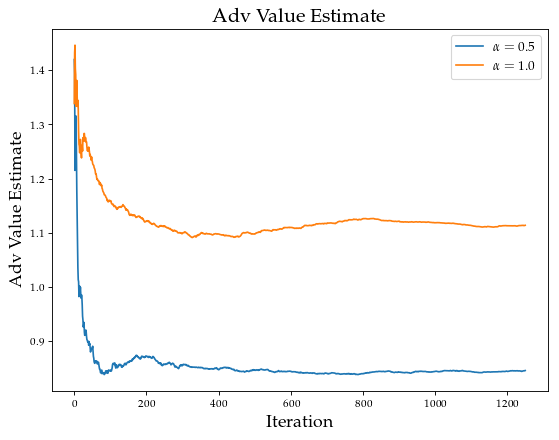

In [23]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,a in enumerate([0.5,1.0]):
    plt.plot(np.array(adv_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
plt.title("Adv Value Estimate", fontsize=18)
plt.ylabel("Adv Value Estimate", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [217]:
belief_curves = np.array(belief_curves)

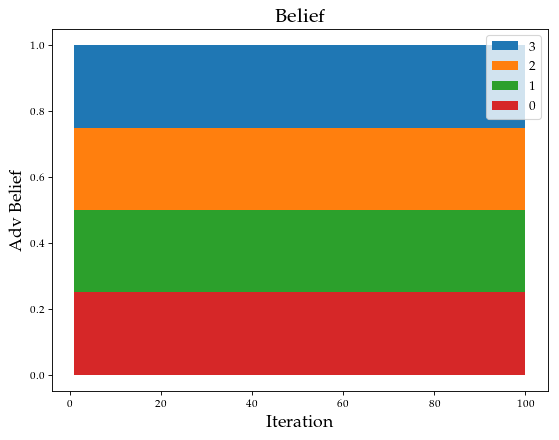

In [61]:
cum_belief_curves = np.cumsum(belief_curves, axis=2)
iterations = np.concatenate([[1],np.arange(cum_belief_curves.shape[1])+1,[cum_belief_curves.shape[1]]])
cum_belief_curves = np.concatenate([np.zeros([cum_belief_curves.shape[0],1,cum_belief_curves.shape[2]]),cum_belief_curves,np.zeros([cum_belief_curves.shape[0],1,cum_belief_curves.shape[2]])], axis=1)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in reversed(range(N_params)):
    plt.fill(iterations,cum_belief_curves[3,:,i], label=str(i))
plt.title("Belief", fontsize=18)
plt.ylabel("Adv Belief", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [29]:
cum_belief_curves.shape

(4, 50, 4)

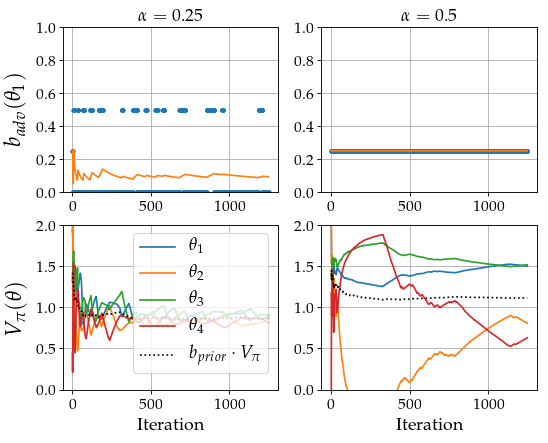

In [25]:
belief_np = np.array(belief_curves)
br_belief_np = np.array(br_belief_curves)
avg_belief_np = np.array(avg_belief_curves)
np_model_vals = np.array(model_value_curves)
performance_on_bavg = np.sum(np_model_vals*avg_belief_np, axis=2)
performance_on_prior = np.sum( np.reshape(belief, [1,1,-1])*np_model_vals, axis=2 )

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
for i,alpha_i in enumerate([0, 1]):
    plt.subplot(2,4,i+1)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.plot(br_belief_np[alpha_i,:,0], label='Best Response Strategy', linestyle='None', marker='.')
    plt.plot(avg_belief_np[alpha_i,:,0], label='Average Strategy')
    #plt.plot(belief_np[alpha_i,:,0], label='Mixed strategy', linestyle=':')
    
    if i == 0:
        plt.ylabel(r"$b_{adv}(\theta_1)$", fontsize=20)
    plt.title(r"$\alpha ="+str(alpha_vals[alpha_i])+r"$", fontsize=16)
    if i == 3:
        plt.legend(fontsize=12, bbox_to_anchor=(0.95, 0.95), loc=1,
                   ncol=1, borderaxespad=0.)
    plt.ylim([0,1])
    plt.grid(True)
    
    plt.subplot(2,4,4+i+1)
    plt.tick_params(axis='both', which='major', labelsize=14)
    for j in range(N_params):
        plt.plot(np_model_vals[alpha_i,:,j], label=r"$\theta_" + str(j+1) + r"$")
    plt.plot(performance_on_prior[alpha_i,:], label=r"$b_{prior} \cdot V_\pi$", linestyle=':', color='k')
    #plt.plot(performance_on_bavg[alpha_i,:], label=r"$\bar{b}_{adv} \cdot V_\pi$")
    
    if i == 0:
        plt.ylabel(r"$V_\pi(\theta)$", fontsize=20)
    if i == 0:
        plt.legend(fontsize=16, bbox_to_anchor=(0.95, 0.95), loc=1,
                   ncol=1, borderaxespad=0.)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylim([0,2])
    plt.grid(True)
plt.show()